### Necesary Libraries

In [1]:
!pip install -q datasets evaluate scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.4 MB/s eta 0:00:00


In [2]:
!pip install -U transformers

In [3]:
import os
os.environ["WANDB_DISABLED"] = "true"

import pandas as pd
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

### Load and Prepare Dataset

In [5]:
df = pd.read_csv("/content/train.csv")
df = df[['comment_text', 'toxic']].dropna().sample(50000, random_state=42)
df = df.rename(columns={'comment_text': 'text', 'toxic': 'label'})
df['label'] = df['label'].astype(int)

# Class balance check
print("Label distribution:")
print(df["label"].value_counts(normalize=True))

Label distribution:
label
0    0.90414
1    0.09586
Name: proportion, dtype: float64


In [6]:
df.head()

,text,label
119105,"Geez, are you forgetful! We've already discus...",0
131631,Carioca RFA \n\nThanks for your support on my ...,0
125326,"""\n\n Birthday \n\nNo worries, It's what I do ...",0
111256,Pseudoscience category? \n\nI'm assuming that ...,0
83590,"(and if such phrase exists, it would be provid...",0


### Token Length Distribution

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (797 > 512). Running this sequence through the model will result in indexing errors


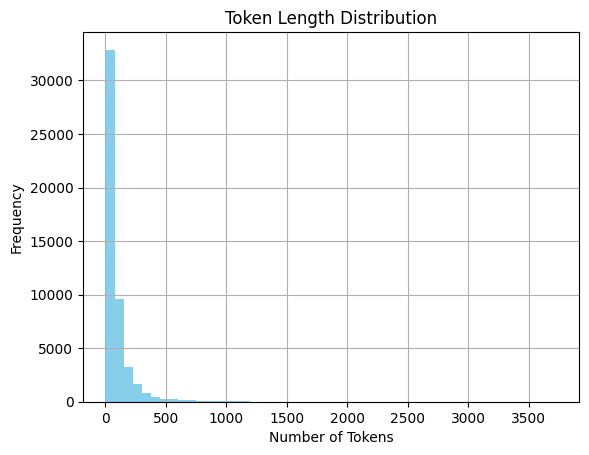

In [7]:
import matplotlib.pyplot as plt

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
token_lengths = [len(tokenizer.tokenize(text)) for text in df["text"]]
plt.hist(token_lengths, bins=50, color='skyblue')
plt.title("Token Length Distribution")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

### Convert to HuggingFace Dataset

In [8]:
dataset = Dataset.from_pandas(df)
dataset = dataset.train_test_split(test_size=0.2)

### Tokenize Text

In [9]:
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

### Load Model & Training Arguments

In [10]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs"
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


### Metrics & Training

In [11]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds),
        "recall": recall_score(labels, preds),
        "f1": f1_score(labels, preds),
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

<ipython-input-11-3477426858>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.111700,0.088665,0.966700,0.841121,0.818182,0.829493
2,0.067700,0.113312,0.966300,0.824230,0.838384,0.831247


TrainOutput(global_step=5000, training_loss=0.09436796913146972, metrics={'train_runtime': 3967.3414, 'train_samples_per_second': 20.165, 'train_steps_per_second': 1.26, 'total_flos': 1.059739189248e+16, 'train_loss': 0.09436796913146972, 'epoch': 2.0})

### Evaluate and Save Model

In [12]:
trainer.evaluate()

model.save_pretrained("model")
tokenizer.save_pretrained("model")


('model/tokenizer_config.json',
 'model/special_tokens_map.json',
 'model/vocab.txt',
 'model/added_tokens.json',
 'model/tokenizer.json')

### Confusion Matrix & Sample Predictions

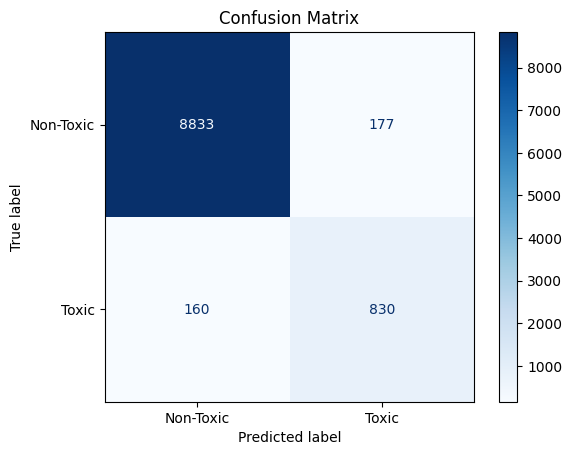

Text: shut up you goddamn assclown....
→ True: 1, Predicted: 1
---
Text: Regarding edits made during October 4 2006 (UTC) to American Revolutionary War
Please do not add non...
→ True: 0, Predicted: 0
---
Text: "

 Reply to your message about style issues and footnotes/references 

Hi! Just so you know, Templa...
→ True: 0, Predicted: 0
---
Text: Please REFRAIN from making edits until I am finished!!!!!
I see that you have tried to remove this m...
→ True: 0, Predicted: 0
---
Text: The last time I edited I wrote to the other editor to discuss the matter in talk page if he wants to...
→ True: 0, Predicted: 0
---


In [13]:
predictions = trainer.predict(tokenized_dataset["test"])
logits = predictions.predictions
labels = predictions.label_ids
preds = logits.argmax(axis=-1)

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Toxic", "Toxic"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

for i in range(5):
    print(f"Text: {dataset['test'][i]['text'][:100]}...")
    print(f"→ True: {labels[i]}, Predicted: {preds[i]}")
    print("---")


In [14]:
!zip -r model.zip model/


  adding: model/ (stored 0%)
  adding: model/special_tokens_map.json (deflated 42%)
  adding: model/vocab.txt (deflated 53%)
  adding: model/model.safetensors (deflated 8%)
  adding: model/tokenizer_config.json (deflated 75%)
  adding: model/tokenizer.json (deflated 71%)
  adding: model/config.json (deflated 45%)


In [15]:
from google.colab import files
files.download("model.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>